In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
# from lib import utils
from scipy.optimize import curve_fit
from gp_growth import gompertz, factory, metric,plot, normal
from gp_growth.storage import mongo
import GPy
import matplotlib.pyplot as plt

RuntimeError: module compiled against API version a but this version of numpy is 9

warning in stationary: failed to import cython module: falling back to numpy


/home/ptonner/dev/gp_growth/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
db = mongo.MongoDB()

In [4]:
growthRate = metric.GrowthRate()

In [5]:
%matplotlib inline

# Standard data only

In [118]:
ylim = (-.4,2.5)

In [133]:
data = db.getData(plate='20150630 PQ 5',Strain=['ura3','sirR'],logged=True,**{'mM PQ':[0,]})
data.data = data.data.iloc[5:,:]
data.data.time = data.data.time - data.data.time.values[0]
data.poly_scale(2,groupby='Strain')

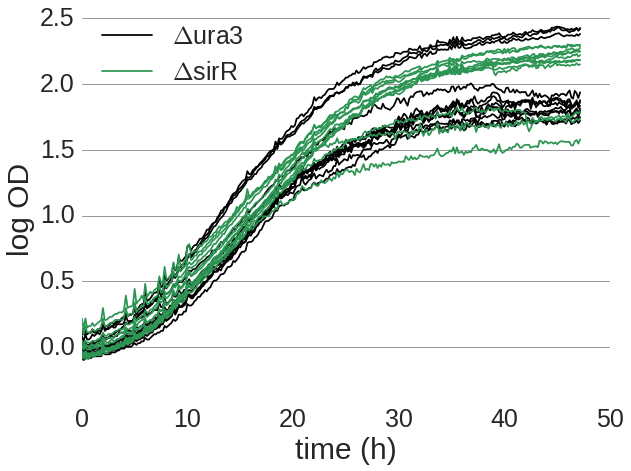

In [134]:
plt.figure(figsize=(8,6))

data.plot(groupby=['mM PQ'],colorby="Strain",newFig=False,colors=['k',c1])
plt.ylabel("log OD",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("time (h)",fontsize=30)
plt.ylim(ylim)
l = plt.legend(loc=(.02,.8),fontsize=25)
[t.set_text('$\Delta$'+t.get_text()) for t in l.get_texts()]
plt.grid(True,axis="y",color="k",alpha=.4)
plt.title("")

plt.savefig("figures/sirR_vs_ura3_standard.png",bbox_inches="tight",dpi=300)

In [135]:
fact = factory.ProductFactory()
fact.addInputDimension("Strain")
fact.setMultiplicationDimension([['time','Strain']])
print fact.buildKernel()

  mul.                |  Value  |  Constraint  |  Prior  |  Tied to
  time.variance       |    1.0  |     +ve      |         |         
  time.lengthscale    |    1.0  |     +ve      |         |         
  Strain.variance     |    1.0  |     +ve      |         |         
  Strain.lengthscale  |    1.0  |     +ve      |         |         


In [136]:
edata = data.getData("gp",thinning=5)
edata.Strain = edata.Strain != "ura3"

In [137]:
gp = fact.build(edata)
gp.optimize()
print gp


Name                              : GP regression
Log-likelihood                    : 355.254707072
Number of Parameters              : 5
Number of Optimization Parameters : 5
Updates                           : True
Parameters:
  GP_regression.           |       Value       |  Constraint  |  Prior  |  Tied to
  mul.time.variance        |    1.30740817519  |     +ve      |         |         
  mul.time.lengthscale     |    20.1507836584  |     +ve      |         |         
  mul.Strain.variance      |    1.30740817536  |     +ve      |         |         
  mul.Strain.lengthscale   |    20.0249900292  |     +ve      |         |         
  Gaussian_noise.variance  |  0.0336729062363  |     +ve      |         |         


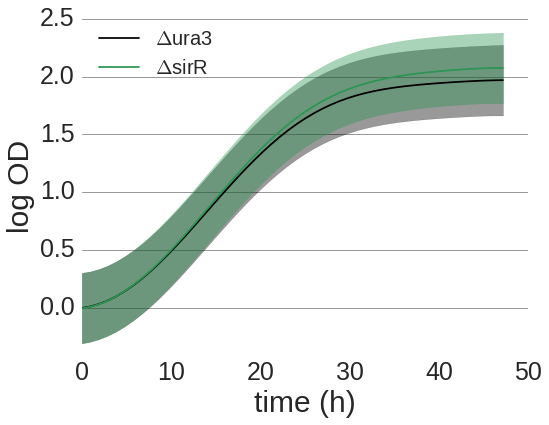

In [138]:
xpred = np.zeros((50,2))
xpred[:,0] = np.linspace(0,data.data.time.max())

mu,var = gp.predict(xpred,full_cov=True)
parent = normal.MultivariateNormal(mu,var)

xpred[:,1] = 1
mu,var = gp.predict(xpred,full_cov=True)
mutant = normal.MultivariateNormal(mu,var)

plt.figure(figsize=(8,6))
parent.plot(xpred[:,0],color='k',alpha=.4,label="ura3")
mutant.plot(xpred[:,0],color=colors[1],alpha=.4,label="sirR")
plt.ylabel("log OD",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("time (h)",fontsize=30)
plt.ylim(ylim)
l = plt.legend(loc=(.02,.8),fontsize=20)
[t.set_text('$\Delta$'+t.get_text()) for t in l.get_texts()]
plt.grid(True,axis="y",color="k",alpha=.4)
plt.title("")

plt.savefig("figures/sirR_vs_ura3_gp_standard.png",bbox_inches="tight",dpi=300)

In [85]:
fact_null = factory.Factory()

gp_null = fact_null.build(edata)
gp_null.optimize()
print gp_null


Name                              : GP regression
Log-likelihood                    : 335.969656472
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  time.variance            |   1.57227178842  |     +ve      |         |         
  time.lengthscale         |   19.7096061276  |     +ve      |         |         
  Gaussian_noise.variance  |  0.034822088201  |     +ve      |         |         


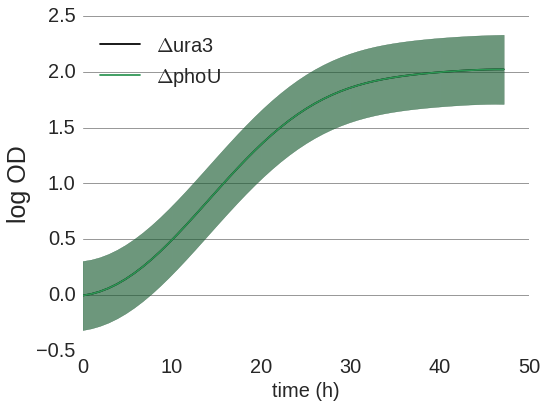

In [86]:
xpred = np.zeros((50,2))
xpred[:,0] = np.linspace(0,data.data.time.max())

mu,var = gp_null.predict(xpred,full_cov=True)
parent = normal.MultivariateNormal(mu,var)

xpred[:,1] = 1
mu,var = gp_null.predict(xpred,full_cov=True)
mutant = normal.MultivariateNormal(mu,var)

plt.figure(figsize=(8,6))
parent.plot(xpred[:,0],color='k',alpha=.4,label="ura3")
mutant.plot(xpred[:,0],color=colors[1],alpha=.4,label="phoU")
plt.ylabel("log OD",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("time (h)",fontsize=20)
l = plt.legend(loc=(.02,.76),fontsize=20)
[t.set_text('$\Delta$'+t.get_text()) for t in l.get_texts()]
plt.grid(True,axis="y",color="k",alpha=.4)
plt.title("")

plt.savefig("figures/sirR_vs_ura3_gp_null.png",bbox_inches="tight",dpi=300)

In [139]:
bf = gp.log_likelihood() - gp_null.log_likelihood()

In [140]:
bf

19.285050599796136

In [147]:
gp.kern.Strain.lengthscale = 1

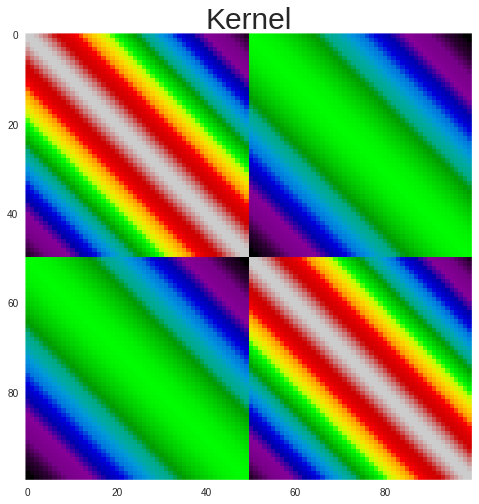

In [152]:
xpred = np.zeros((100,2))
xpred[:50,0] = xpred[50:,0] = np.linspace(0,50)
xpred[50:,1] = 1

plt.figure(figsize=(8,8))
plt.imshow(gp.kern.K(xpred),cmap="spectral",interpolation="none")
plt.grid(False)
plt.title("Kernel",fontsize=30)
plt.savefig("figures/phoU_vs_ura3_standard_kernel.png",bbox_inches="tight")

In [42]:
bfsPermuted = []
for i in range(10):
    order = np.random.choice(range(data.key.shape[0]),data.key.shape[0],replace=False)
    data.key.Strain = data.key.Strain[order].values

    edata = data.getData("gp",thinning=5)
    edata.Strain = edata.Strain != "ura3"
    
    gp = fact.build(edata)
    gp.optimize()
    bfsPermuted.append(gp.log_likelihood() - gp_null.log_likelihood())
    
bfsPermuted = np.array(bfsPermuted)

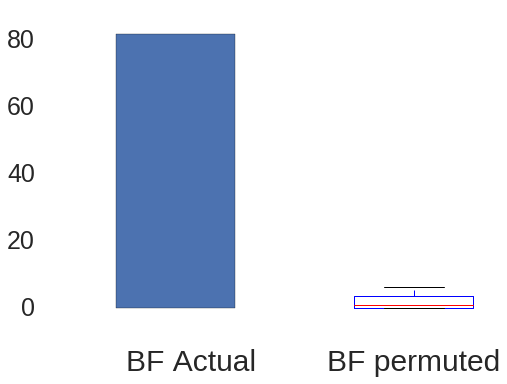

In [68]:
plt.figure(figsize=(8,6))

plt.bar(-.5,bf,)
plt.boxplot(bfsPermuted,positions=[1.5],widths=[.8])

plt.xticks([0,1.5],["BF Actual","BF permuted"],fontsize=30)
plt.yticks(fontsize=25)

plt.xlim(-1,2)

plt.savefig("figures/phoU_vs_ura3_bf.png",bbox_inches="tight")

# Paraquat only 

In [153]:
data = db.getData(plate='20150630 PQ 5',Strain=['ura3','sirR'],logged=True,**{'mM PQ':[0.333,]})
data.data = data.data.iloc[5:,:]
data.data.time = data.data.time - data.data.time.values[0]
data.poly_scale(2,groupby='Strain')

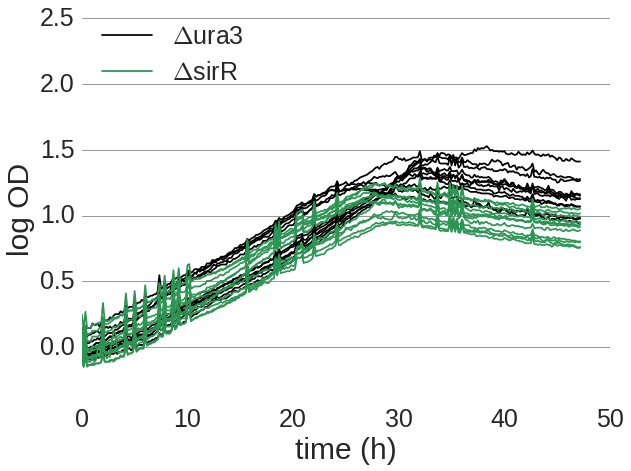

In [154]:
plt.figure(figsize=(8,6))

data.plot(groupby=['mM PQ'],colorby="Strain",newFig=False,colors=['k',c1])
plt.ylabel("log OD",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("time (h)",fontsize=30)
plt.ylim(ylim)
l = plt.legend(loc=(.02,.8),fontsize=25)
[t.set_text('$\Delta$'+t.get_text()) for t in l.get_texts()]
plt.grid(True,axis="y",color="k",alpha=.4)
plt.title("")

plt.savefig("figures/sirR_vs_ura3_paraquat.png",bbox_inches="tight",dpi=300)

In [155]:
fact = factory.ProductFactory()
fact.addInputDimension("Strain")
fact.setMultiplicationDimension([['time','Strain']])
print fact.buildKernel()

  mul.                |  Value  |  Constraint  |  Prior  |  Tied to
  time.variance       |    1.0  |     +ve      |         |         
  time.lengthscale    |    1.0  |     +ve      |         |         
  Strain.variance     |    1.0  |     +ve      |         |         
  Strain.lengthscale  |    1.0  |     +ve      |         |         


In [156]:
data = db.getData(plate='20150630 PQ 5',Strain=['ura3','sirR'],logged=True,**{'mM PQ':0.333})
data.data = data.data.iloc[5:,:]
data.data.time = data.data.time - data.data.time.values[0]
data.poly_scale(2,groupby='Strain')
edata = data.getData("gp",thinning=5)
edata.Strain = edata.Strain != "ura3"

gp = fact.build(edata)
gp.optimize()

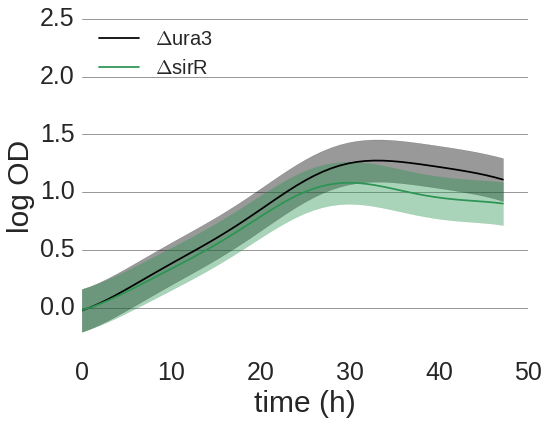

In [157]:
xpred = np.zeros((50,2))
xpred[:,0] = np.linspace(0,data.data.time.max())

mu,var = gp.predict(xpred,full_cov=True)
parent = normal.MultivariateNormal(mu,var)

xpred[:,1] = 1
mu,var = gp.predict(xpred,full_cov=True)
mutant = normal.MultivariateNormal(mu,var)

plt.figure(figsize=(8,6))
parent.plot(xpred[:,0],color='k',alpha=.4,label="ura3")
mutant.plot(xpred[:,0],color=colors[1],alpha=.4,label="sirR")
plt.ylabel("log OD",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("time (h)",fontsize=30)
plt.ylim(ylim)
l = plt.legend(loc=(.02,.8),fontsize=20)
[t.set_text('$\Delta$'+t.get_text()) for t in l.get_texts()]
plt.grid(True,axis="y",color="k",alpha=.4)
plt.title("")

plt.savefig("figures/sirR_vs_ura3_gp_pq.png",bbox_inches="tight",dpi=300)

# Standard and PQ data 

In [6]:
data = db.getData(plate='20150514 PQ 2',Strain=['ura3','phoU'],logged=True,**{'mM PQ':[0,.333]})
data.data = data.data.iloc[5:,:]
data.data.time = data.data.time - data.data.time.values[0]
data.poly_scale(2,groupby='Strain')

In [7]:
xlim = (-3,48)

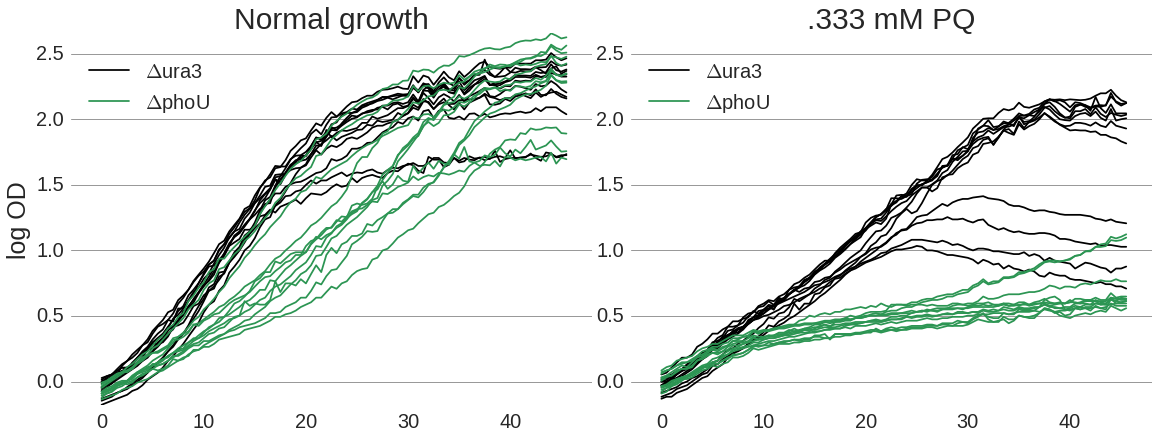

In [8]:
fig = plt.figure(figsize=(16,6))

colors = sns.color_palette("BuGn_r")
c1 = colors[1]
c2 = colors[2]

data.plot(groupby=['mM PQ'],colorby="Strain",newFig=False,colors=['k',c1])

plt.subplot(121)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.xlabel("time (h)",fontsize=20)
plt.ylabel("log OD",fontsize=25)
plt.title("Normal growth",fontsize=30)
l = plt.legend(loc=(.02,.76),fontsize=20)
[t.set_text('$\Delta$'+t.get_text()) for t in l.get_texts()]
plt.grid(True,axis="y",color="k",alpha=.4)
plt.xlim(xlim)

plt.subplot(122)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.xlabel("time (h)",fontsize=20)
# plt.ylabel("log OD",fontsize=20)
plt.title(".333 mM PQ",fontsize=30)
plt.grid(True,axis="y",color="k",alpha=.4)
l = plt.legend(loc=(.02,.76),fontsize=20)
[t.set_text('$\Delta$'+t.get_text()) for t in l.get_texts()]
plt.xlim(xlim)

plt.tight_layout(pad=.4)

plt.savefig("figures/phoU_vs_ura3_pq.png",bbox_inches="tight",dpi=300)

In [86]:
s = ''

In [ ]:
s.

In [88]:
data.key.head()


[0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3]

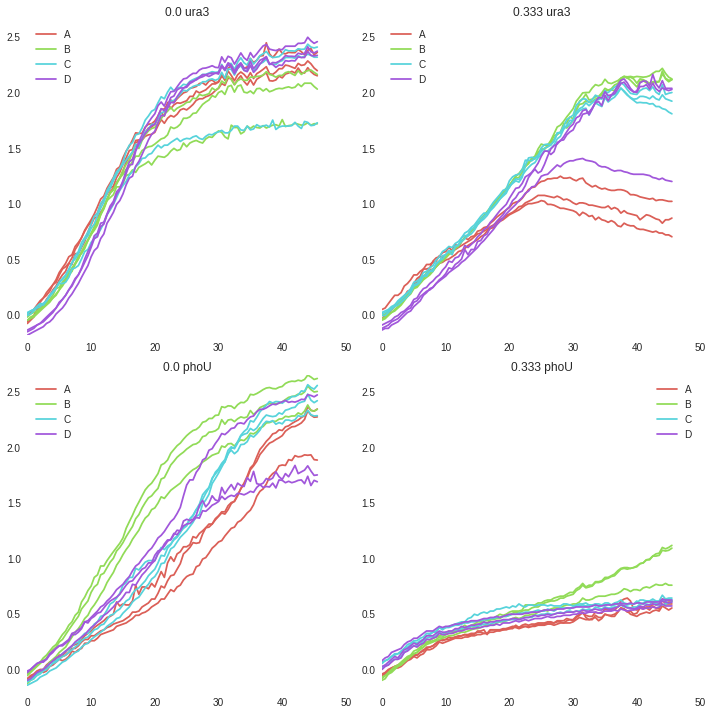

In [96]:
plt.figure(figsize=(10,10))
data.plot(groupby=['mM PQ','Strain'],colorby="Bio",groupOrder=[1,2,3,0],ncols=2,newFig=False)
plt.savefig("figures/data_bio_example.png")

In [8]:
fact = factory.Factory()

In [19]:
fact = factory.ProductFactory()
fact.addInputDimension("Strain")
fact.setMultiplicationDimension([['time','Strain']])
print fact.buildKernel()

  mul.                |  Value  |  Constraint  |  Prior  |  Tied to
  time.variance       |    1.0  |     +ve      |         |         
  time.lengthscale    |    1.0  |     +ve      |         |         
  Strain.variance     |    1.0  |     +ve      |         |         
  Strain.lengthscale  |    1.0  |     +ve      |         |         


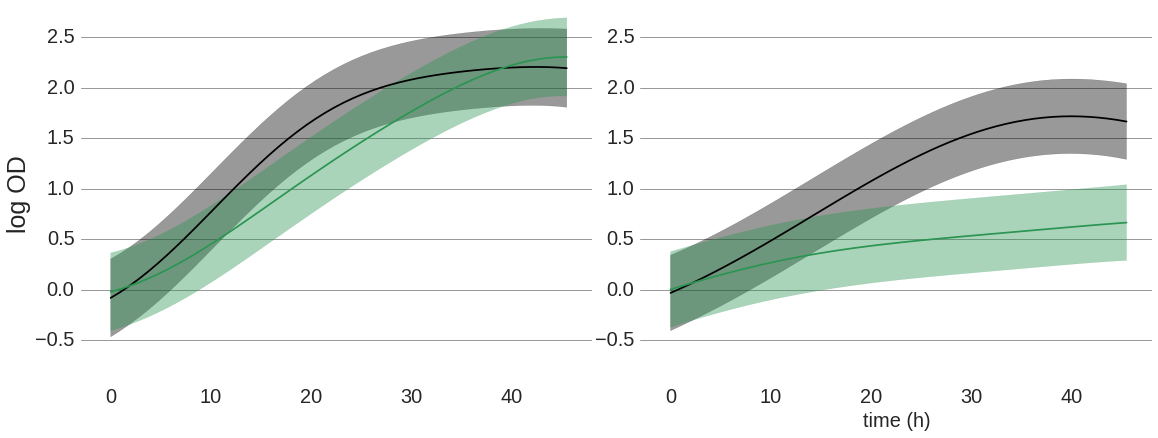

In [69]:
plt.figure(figsize=(16,6))

for conc in [0.0,.333]:
    
    data = db.getData(plate='20150514 PQ 2',Strain=['ura3','phoU'],logged=True,**{'mM PQ':conc})
    data.data = data.data.iloc[5:,:]
    data.data.time = data.data.time - data.data.time.values[0]
    data.poly_scale(2,groupby='Strain')
    edata = data.getData("gp",thinning=5)
    edata.Strain = edata.Strain != "ura3"

    gp = fact.build(edata)
    gp.optimize()
    
    xpred = np.zeros((50,2))
    xpred[:,0] = np.linspace(0,data.data.time.max())
       
    mu,var = gp.predict(xpred,full_cov=True)
    parent = normal.MultivariateNormal(mu,var)
    
    xpred[:,1] = 1
    mu,var = gp.predict(xpred,full_cov=True)
    mutant = normal.MultivariateNormal(mu,var)
    
    if conc == 0:
        ax = plt.subplot(121)
    else:
        ax =plt.subplot(122)
    
    parent.plot(xpred[:,0],color='k',alpha=.4)
    mutant.plot(xpred[:,0],color=colors[1],alpha=.4)
    
plt.subplot(121)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.xlabel("time (h)",fontsize=20)
plt.ylabel("log OD",fontsize=25)
# plt.title("Normal growth",fontsize=30)
plt.grid(True,axis="y",color="k",alpha=.4)
plt.ylim(-.9,2.8)
plt.xlim(xlim)

plt.subplot(122)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("time (h)",fontsize=20)
# plt.title(".333 mM PQ",fontsize=30)
plt.grid(True,axis="y",color="k",alpha=.4)
plt.ylim(-.9,2.8)
plt.xlim(xlim)

plt.tight_layout(pad=.4)

plt.savefig("figures/phoU_vs_ura3_pq_gp.png",bbox_inches="tight",dpi=300)

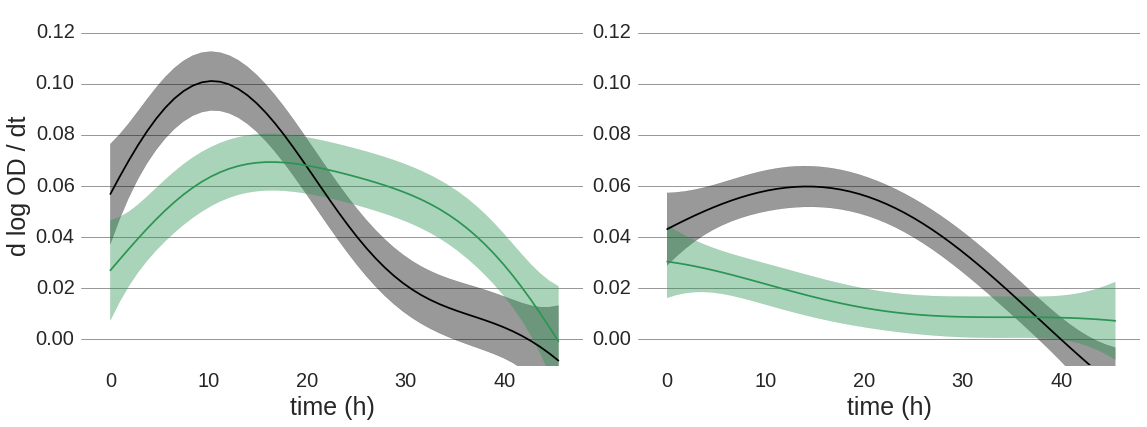

In [70]:
plt.figure(figsize=(16,6))

for conc in [0.0,.333]:
    
    data = db.getData(plate='20150514 PQ 2',Strain=['ura3','phoU'],logged=True,**{'mM PQ':conc})
    data.data = data.data.iloc[5:,:]
    data.data.time = data.data.time - data.data.time.values[0]
    data.poly_scale(2,groupby='Strain')
    edata = data.getData("gp",thinning=5)
    edata.Strain = edata.Strain != "ura3"

    gp = fact.build(edata)
    gp.optimize()
    
    xpred = np.zeros((50,2))
    xpred[:,0] = np.linspace(0,data.data.time.max())
    
    # mu,var = growthRate(predictive_data=xpred,model=gp)
    mu,_ = gp.predictive_gradients(xpred)
    mu = mu[:,0]
    _,cov = gp._raw_predict(xpred,full_cov=True)
    mult = [[((1./gp.kern.time.lengthscale)*(1-(1./gp.kern.time.lengthscale)*(y[0] - z[0])**2))[0] for y in xpred] for z in xpred]
    parent = normal.MultivariateNormal(mu,mult*cov)
    
    xpred[:,1] = 1
    mu,_ = gp.predictive_gradients(xpred)
    mu = mu[:,0]
    _,cov = gp._raw_predict(xpred,full_cov=True)
    mult = [[((1./gp.kern.time.lengthscale)*(1-(1./gp.kern.time.lengthscale)*(y[0] - z[0])**2))[0] for y in xpred] for z in xpred]
    mutant = normal.MultivariateNormal(mu,mult*cov)
    
    if conc == 0:
        ax = plt.subplot(121)
    else:
        ax =plt.subplot(122)
    
    parent.plot(xpred[:,0],color='k',alpha=.4)
    mutant.plot(xpred[:,0],color=colors[1],alpha=.4)
    
plt.subplot(121)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("time (h)",fontsize=25)
plt.ylabel("d log OD / dt",fontsize=25)
# plt.title("Normal growth",fontsize=30)
plt.grid(True,axis="y",color="k",alpha=.4)
plt.ylim(-0.01, 0.13)
plt.xlim(xlim)


plt.subplot(122)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("time (h)",fontsize=25)
# plt.title(".333 mM PQ",fontsize=30)
plt.grid(True,axis="y",color="k",alpha=.4)
plt.ylim(-0.01, 0.13)
plt.xlim(xlim)

plt.tight_layout(pad=1)

plt.savefig("figures/phoU_vs_ura3_pq_gpDeriv.png",bbox_inches="tight",dpi=300)

# All data for supplement 

In [97]:
plates = [u'20150715 PQ 8',
 u'20150607 PQ 4',
 u'20150630 PQ 5',
 u'20150717 PQ 9',
 u'20150514 PQ 2',
 u'20150702 PQ 6',
 u'20150704 PQ 7']

In [100]:
for p in plates:
    strains = db.getExperimentalDesigns("Strain",plate=p)
    strains.remove("blank")
    
#     for s in strains:
    data = db.getData(plate=p,Strain=strains,logged=True,**{'mM PQ':[0,.333]})
    data.data = data.data.iloc[5:,:]
    data.data.time = data.data.time - data.data.time.values[0]
    data.poly_scale(2,groupby='Strain')
    
    data.plot(groupby="Strain",colorby="mM PQ",output="figures/alldata_%s.png"%p)